## Example of Jupyter/Ginga widget

This is an example of creating a Jupyter data viewer widget using a ipywidgets image
widget and the Ginga viewer toolkit.

### *NOTE*: To use these examples, you need to install the `ipyevents` package:

`$ pip install ipyevents`

`$ jupyter nbextension install --py --sys-prefix ipyevents`

`$ jupyter nbextension enable --py --sys-prefix ipyevents`

See https://github.com/mwcraig/ipyevents for JupyterLab installation instructions.

In [1]:
# create a Jupyter image that will be our display surface
# format can be 'jpeg' or 'png'; specify width and height to set viewer size
# PNG will be a little clearer, especially with overlaid graphics, but
# JPEG is faster to update
import ipywidgets as widgets
jup_img = widgets.Image(format='png', width=500, height=500)

In [2]:
# Boilerplate to create a Ginga viewer connected to this widget
# this could be simplified, or hidden behind a class or convenience 
# method
# NOTE: you don't have to specify a log file--and if you are not interested
# in the log just specify null=True for a null logger
# level=10 will give you the most debugging information
from ginga.misc.log import get_logger
logger = get_logger("my viewer", log_stderr=False, log_file='/tmp/ginga.log', level=40)

from ginga.web.jupyterw.ImageViewJpw import EnhancedCanvasView
v1 = EnhancedCanvasView(logger=logger)
# set our linkage between the jupyter widget at ginga
v1.set_widget(jup_img)

# enable all possible keyboard and pointer operations
bd = v1.get_bindings()
bd.enable_all(True)
# if you want to be able to see what keyboard enabled modes
# you have entered
v1.show_mode_indicator(True)

In [3]:
coordinates = widgets.HTML('<h3>coordinates show up here</h3>')

# callback to display position in RA/DEC deg
def mouse_move(viewer, button, data_x, data_y, w):
    image = viewer.get_image()
    if image is not None:
        ra, dec = image.pixtoradec(data_x, data_y)
        w.value = "cursor at %f, %f" % (ra, dec)

v1.add_callback('cursor-changed', mouse_move, coordinates)


In [4]:
%%javascript
/* some magic to keep the cell contents from scrolling
   (when we embed the viewer)
 */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# embed the viewer here
# NOTE: when subsequent cells say to interact with the viewer/image, they mean THIS image!!
#  (NOT screenshots captured by v1.show())
widgets.VBox([jup_img, coordinates])

In [6]:
# Load a FITS file.  You should see the embedded image update.
v1.load_fits("/home/eric/testdata/SPCAM/SUPA01118766.fits")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2009-08-22T09:35:55.248' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


You can now do nearly everything that can be done with a regular "pg" type ginga web widget.
See http://ginga.readthedocs.io/en/latest/quickref.html for default key and button/pointer bindings.

See https://github.com/ejeschke/ginga/blob/main/ginga/examples/jupyter-notebook/ginga_ipython_demo.ipynb
for the kinds of things you can do with the embedded viewer including graphics overplotting, etc.

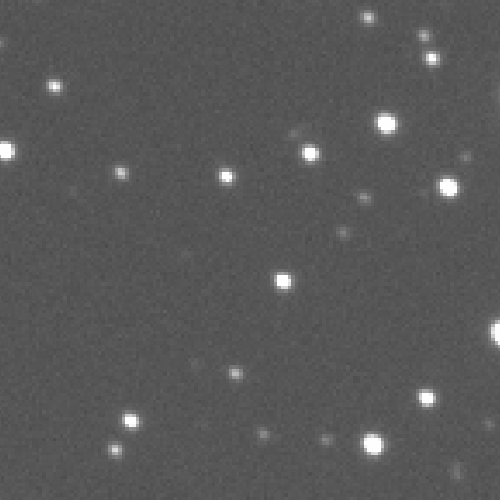

In [7]:
# grab a screenshot.
v1.show()

In [8]:
# add a canvas to the image and set the draw type
canvas = v1.add_canvas()
canvas.set_drawtype('ellipse', color='orange', fill=True, fillcolor='cyan', fillalpha=0.3)

Now draw the shape using the right mouse button. Or press Spacebar, then 'b' to enter Draw mode and draw with the first mouse button or touchpad (press ESC to exit Draw mode).

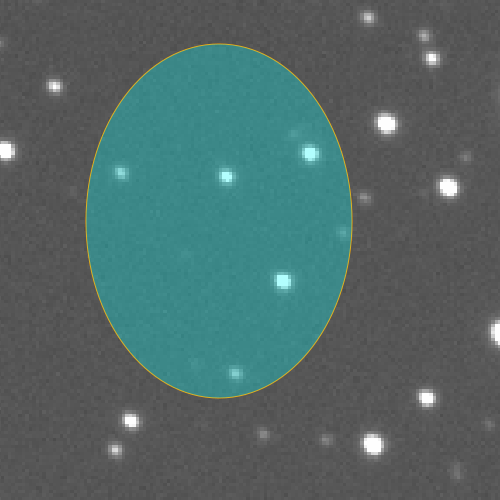

In [10]:
v1.show()

In [11]:
# put the canvas in edit mode
canvas.enable_edit(True)
canvas.set_draw_mode('edit')

Now you can click on the object to select it and edit it.  Editing control points should appear:
- orange: stretch or shrink dimension(s)
- green: scale object while keeping aspect
- blue: rotate object
- red: move object
You can also move objects simply by dragging anywhere in the bounding box if they are selected.

In [12]:
canvas.get_objects()

In [13]:
# let's get the object that we drew--what is it's location?
ell = canvas.get_objects()[0]
ell.x, ell.y

(1245.2167909669952, 2293.8351163867983)

In [14]:
ell.xradius, ell.yradius

(27.576508024306634, 49.93894979117732)

In [21]:
# delete everything on the canvas that we drew
canvas.delete_all_objects()